In [2]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import matplotlib.colors as colors
from sklearn.cluster import MeanShift
from itertools import cycle

In [4]:
c =0.299792458
n =1.3195
v=c/n 
print(v)

0.2272015596816976


In [5]:
info = pickle.load(open("./double_pulse/DP_Tau1PeV_Big.pkl", "rb"))
data = np.load("./double_pulse/DP_Tau1PeV_Big_data.npy")
print len(info), len(data)

SyntaxError: invalid syntax (<ipython-input-5-9296a28649f5>, line 3)

In [4]:
for event in data:
    for i in event:
        if i[4] <0:
            i[4] = 0

In [5]:
D = data[57]
I = info[57]
print len(D), len(I)

168704 11


In [6]:
for i,e in enumerate(info):
    print i, e["id"],"E_nu={0:2.2e} E_tau={1:2.2e} Qtot={2:.2f}".format(e['nu_energy'], e['tau_energy'], e['qtotal'])

0 (76, 4294967295, 631, 0) E_nu=1.43e+06 E_tau=1.06e+06 Qtot=120.10
1 (86, 4294967295, 261, 0) E_nu=1.32e+06 E_tau=1.16e+06 Qtot=23433.80
2 (72, 4294967295, 409, 0) E_nu=1.07e+06 E_tau=1.03e+06 Qtot=74635.15
3 (72, 4294967295, 436, 0) E_nu=1.17e+06 E_tau=1.07e+06 Qtot=82397.20
4 (72, 4294967295, 737, 0) E_nu=1.05e+06 E_tau=1.02e+06 Qtot=33997.90
5 (30, 4294967295, 99, 0) E_nu=1.53e+06 E_tau=1.00e+06 Qtot=1325.27
6 (30, 4294967295, 189, 0) E_nu=1.00e+06 E_tau=1.00e+06 Qtot=98646.33
7 (30, 4294967295, 277, 0) E_nu=1.55e+06 E_tau=1.16e+06 Qtot=3747.80
8 (30, 4294967295, 533, 0) E_nu=1.35e+06 E_tau=1.10e+06 Qtot=1894.08
9 (19, 4294967295, 133, 0) E_nu=1.07e+06 E_tau=1.07e+06 Qtot=65422.35
10 (19, 4294967295, 314, 0) E_nu=2.21e+06 E_tau=1.08e+06 Qtot=10390.80
11 (28, 4294967295, 340, 0) E_nu=1.15e+06 E_tau=1.11e+06 Qtot=635.07
12 (28, 4294967295, 630, 0) E_nu=1.02e+06 E_tau=1.01e+06 Qtot=645.77
13 (28, 4294967295, 634, 0) E_nu=1.52e+06 E_tau=1.19e+06 Qtot=3869.20
14 (98, 4294967295, 569, 0)

In [7]:
def make_plots(labels, data, truth):
   
    mask_b1 = labels==0
    mask_b2 = labels==1
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111, projection='3d')
    ax.scatter(data[mask_b1][:,0],data[mask_b1][:,1],data[mask_b1][:,2],s=data[mask_b1][:,4],c='r',alpha =0.05,marker='.')
    ax.scatter(data[mask_b2][:,0],data[mask_b2][:,1],data[mask_b2][:,2],s=data[mask_b2][:,4],c='b',alpha =0.05,marker='.')
    ax.scatter(truth[:,0], truth[:,1], truth[:,2], s=truth[:,4], c='g', marker='.')
    ax.view_init(0, 0)
    
    fig2 = plt.figure(figsize=(6, 6))
    ax = fig2.add_subplot(311)
    ax.set_xlabel("Time, ns", fontsize = 14)                                                              
    ax.set_ylabel("X, m", fontsize = 14)
    ax.scatter(data[mask_b1][:,3], data[mask_b1][:,0], s=data[mask_b1][:,4], c='r',alpha =0.05,marker='.')
    ax.scatter(data[mask_b2][:,3], data[mask_b2][:,0], s=data[mask_b2][:,4], c='b',alpha =0.05,marker='.')
    ax.scatter(truth[:,3], truth[:,0], s=truth[:,4], c='g', marker='.')
    ax = fig2.add_subplot(312)
    ax.set_xlabel("Time, ns", fontsize = 14)                                                              
    ax.set_ylabel("Y, m", fontsize = 14)
    ax.scatter(data[mask_b1][:,3], data[mask_b1][:,1], s=data[mask_b1][:,4], c='r',alpha =0.05,marker='.')
    ax.scatter(data[mask_b2][:,3], data[mask_b2][:,1], s=data[mask_b2][:,4], c='b',alpha =0.05,marker='.')
    ax.scatter(truth[:,3], truth[:,0], s=truth[:,4], c='g', marker='.')
    ax = fig2.add_subplot(313)
    ax.set_xlabel("Time, ns", fontsize = 14)                                                              
    ax.set_ylabel("Z, m", fontsize = 14)
    ax.scatter(data[mask_b1][:,3], data[mask_b1][:,2], s=data[mask_b1][:,4], c='r',alpha =0.05,marker='.')
    ax.scatter(data[mask_b2][:,3], data[mask_b2][:,2], s=data[mask_b2][:,4], c='b',alpha =0.05,marker='.')
    ax.scatter(truth[:,3], truth[:,0], s=truth[:,4], c='g', marker='.')

    
    plt.show()

In [8]:
def make_movie(labels, data, truth, persistent = False):
    
    time_step = 10 #ns
    data[data[:, 3].argsort()]
    time_bins = range(int(np.min(data[:,3])), int(np.max(data[:,3])), time_step)
    for bin_edge in time_bins:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(0, 30)
        ax.set_xlim(-500,500)
        ax.set_ylim(-500,500)
        ax.set_zlim(-500,500)
        if not persistent:
            time_mask = np.logical_and(data[:,3]>=bin_edge, data[:,3]<bin_edge+time_step)
        else:
            time_mask = data[:,3]<bin_edge+time_step
        mask_b1 = (labels==0) & time_mask
        mask_b2 = (labels==1) & time_mask
        name = '/home/dup193/work/notebook/movie/pic_times_{0:04d}.png'.format(time_bins.index(bin_edge))
        ax.text(0.5, 1, z, "time = {0}".format(bin_edge), zdir=None,  horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.scatter(data[mask_b1][:,0], data[mask_b1][:,1], data[mask_b1][:,2], s=data[mask_b1][:,4], c='r', marker='.')
        ax.scatter(data[mask_b2][:,0], data[mask_b2][:,1], data[mask_b2][:,2], s=data[mask_b2][:,4], c='b', marker='.')
        ax.scatter(truth[:,0], truth[:,1], truth[:,2], s=truth[:,4], c='g', marker='.')
        plt.savefig(name)
        print name
        plt.close(fig)


In [9]:
def make_waveforms(labels,data,info):
    print labels.shape, data.shape, len(info)
    qdoms = -np.unique(-data[:,9])[:30]
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    for i, q in enumerate(qdoms):
        mask = data[:,9]==q 
        wf_data = data[mask]
        if len(wf_data) != 128:
            print wf_data[:,5]
            print wf_data[:,6]
        wf_labels = labels[mask]
        wf_data[wf_data[:, 3].argsort()]
        max_wf = np.max(wf_data[:,4])
        ax = fig.add_subplot(10, 3, i+1)
        ax.text(wf_data[0][3], max_wf*1.0, "{0},{1}, E{2:2.2e}GeV, Q{3:.1f}PE, q{4:.1f}PE".format(wf_data[0][7],wf_data[0][8],info["tau_energy"],info["qtotal"],q), color="k",fontsize = 16 )     
        ax.set_ylim(0,max_wf*1.2)
        
        mask_b1 = wf_labels==0
        mask_b2 = wf_labels==1
        
        ax.plot(wf_data[mask_b1][:,3],wf_data[mask_b1][:,4],'r', label = "ONE")
        ax.plot(wf_data[mask_b2][:,3],wf_data[mask_b2][:,4],'b', label = "TWO")
            
    fig.tight_layout()
    #name_0 = name+"_{0}.png".format(data.index(i))
    #plt.savefig(name_0)
    plt.show()
    #plt.close('all')

In [10]:
GooD = []
for d in D:
    #if (d[6] != 0) and (d[6] != 0):
    #    print d[5], d[6]
    if d[6] == 0:
        GooD.append(d)
GooD = np.vstack(GooD)
print GooD.shape

(130560, 10)


In [11]:
def bang2_pos_calculate(one, one_dir, length):
    if length > 0:
        l_x = np.sin(one_dir[0])*np.cos(one_dir[1])*length
        l_y = np.sin(one_dir[0])*np.sin(one_dir[1])*length
        l_z = np.cos(one_dir[0])*length
    two = [0,0,0]
    two[0] = one[0]-l_x 
    two[1] = one[1]-l_y 
    two[2] = one[2]-l_z 
    
    return two

In [12]:
true_bangs = []
for e in info:
    b1 = e['tau_position']+(e['tau_time'][0]*v,1000) 
    b2_pos = bang2_pos_calculate(e['tau_position'],e["tau_direction"],e["tau_length"])
    b2 = b2_pos +[e['tau_time'][1]*v,1000]
    
    true_bangs.append(np.stack((b1,b2)))
print true_bangs[57].shape

(2, 5)


In [13]:
#select 10 High Charge DOMS
qs = -np.unique(-GooD[:,9])
#print qs
hq_data = []
for q in qs:
    hq_data.append(GooD[GooD[:,9]==q])
hq_data = np.vstack(hq_data)
print hq_data.shape, hq_data[0]

(130560, 10) [   11.86999989   179.19000244  -297.63000488  2249.86814313     0.             0.
     0.            55.            48.          5332.47497027]


In [14]:
def mink(v,u): 
    return (v[3]-u[3])**2-(v[0]-u[0])**2-(v[1]-u[1])**2-(v[2]-u[2])**2

In [15]:
BRCH = Birch(n_clusters=2).fit(hq_data[:,0:4],hq_data[:,4])
labels_BRCH = BRCH.predict(hq_data[:,0:4])

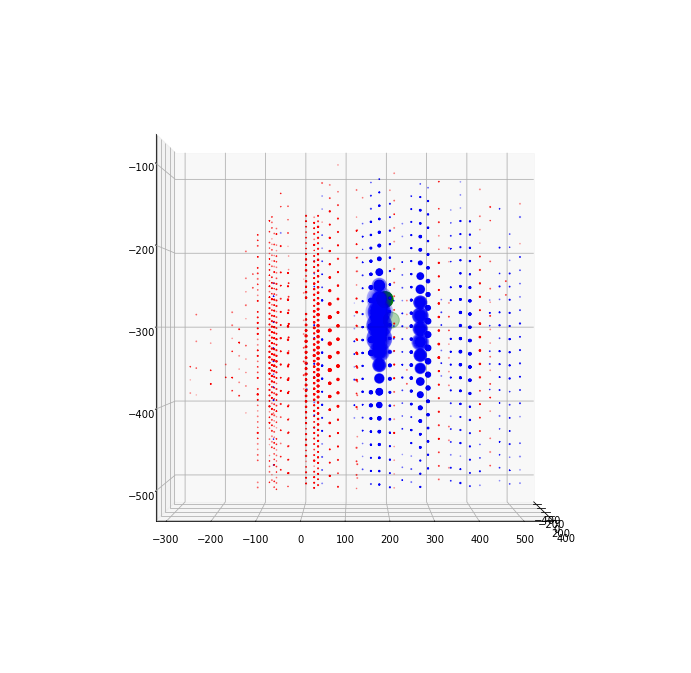

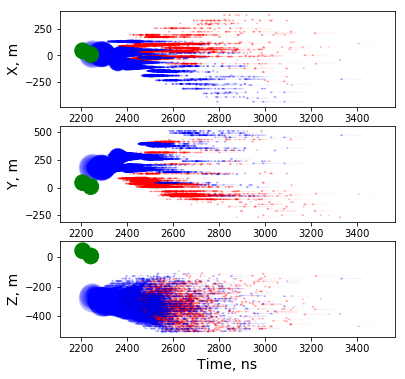

In [16]:
make_plots(labels_BRCH,hq_data,true_bangs[57])

(130560,) (130560, 10) 11


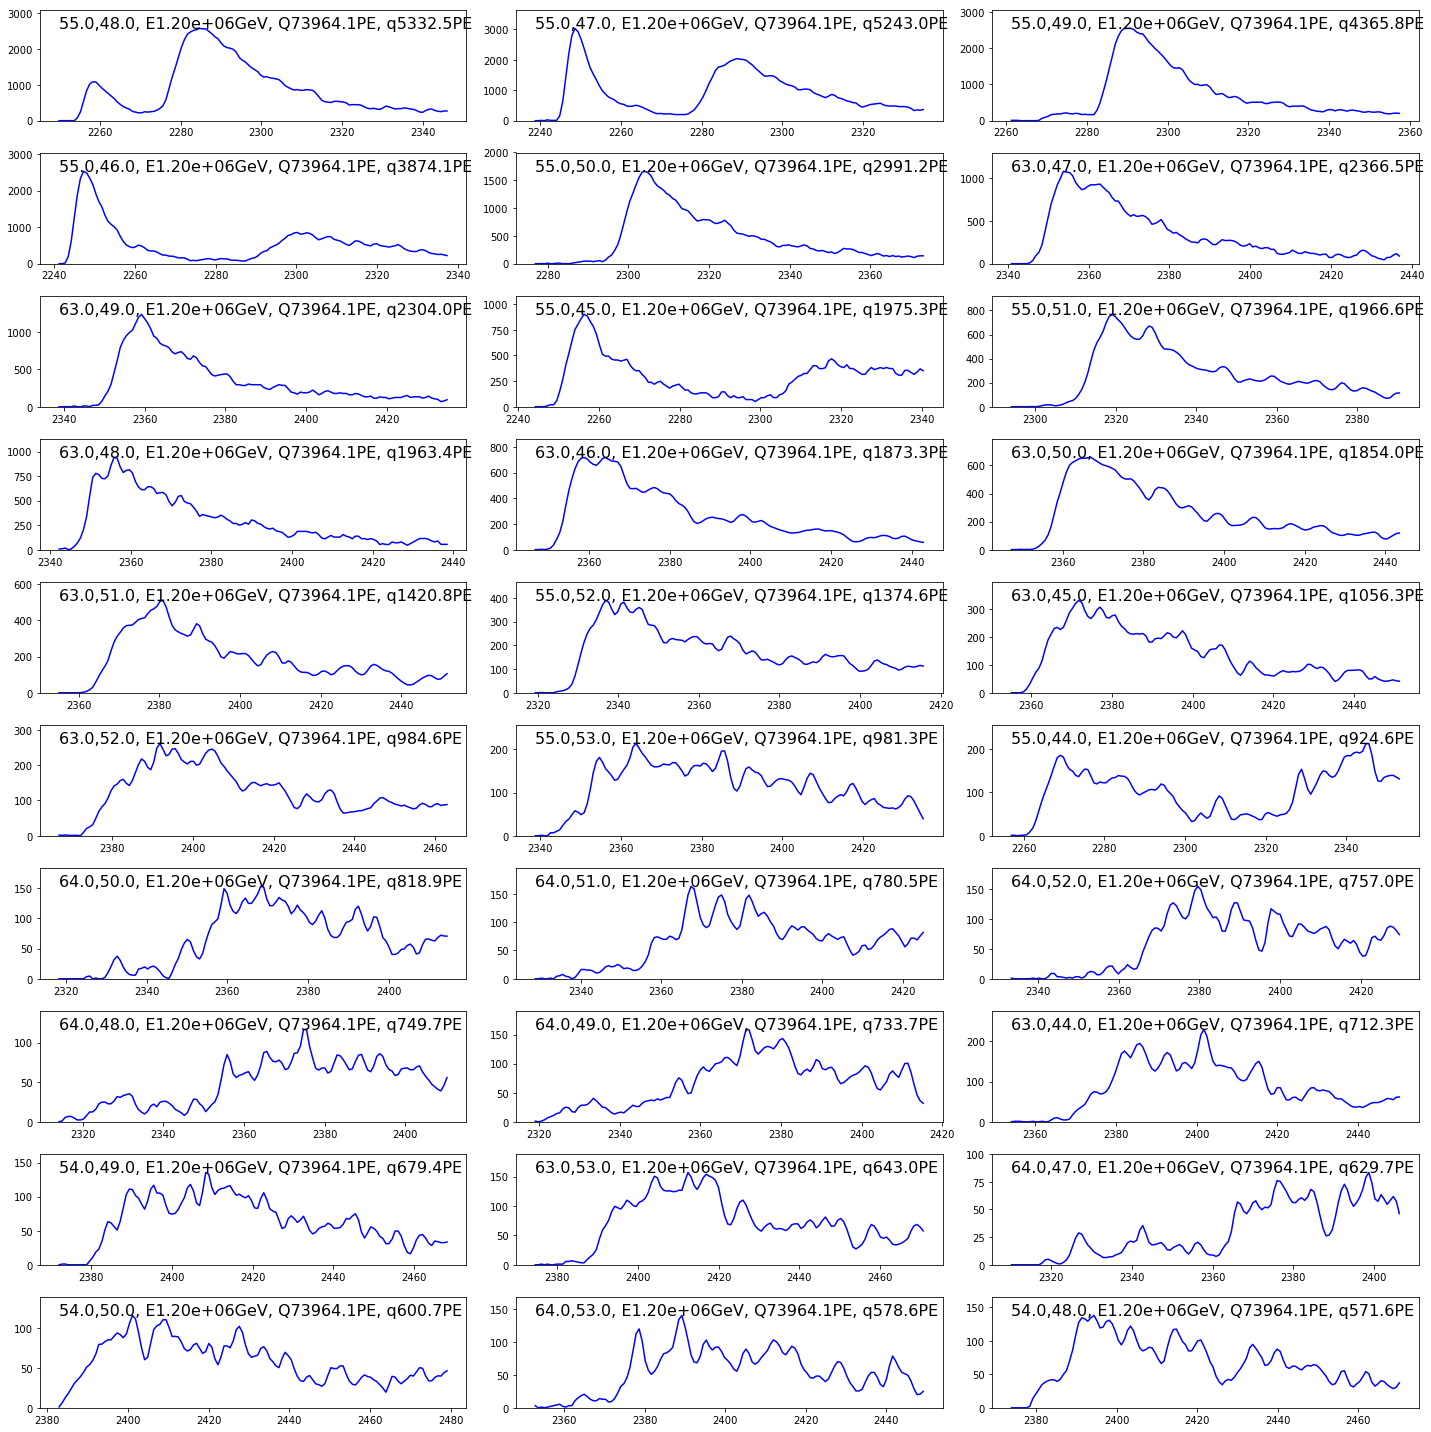

In [17]:
make_waveforms(labels_BRCH,hq_data,I)

In [ ]:
DBS = DBSCAN(eps=500).fit(hq_data[:,0:4],hq_data[:,4])
labels_DBS = DBS.labels_
uni, count = np.unique(labels_DBS, return_counts =True)
print (dict(zip(uni,count)))

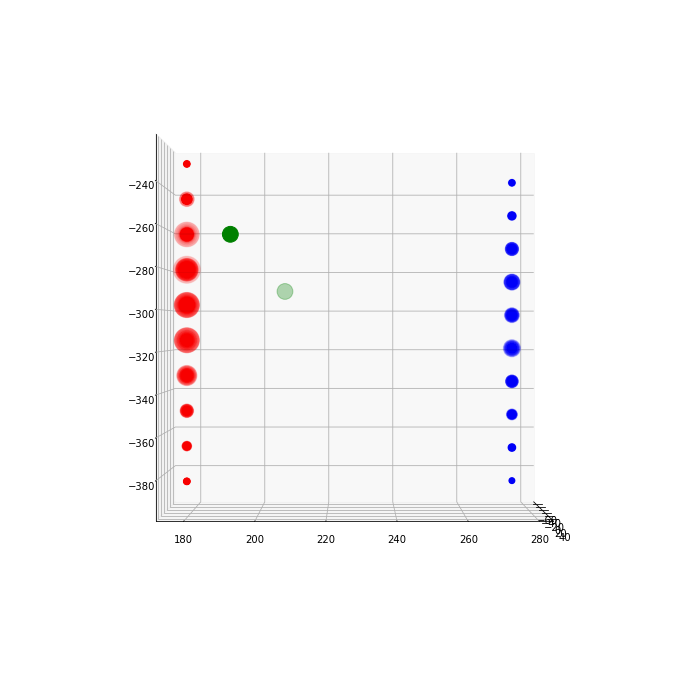

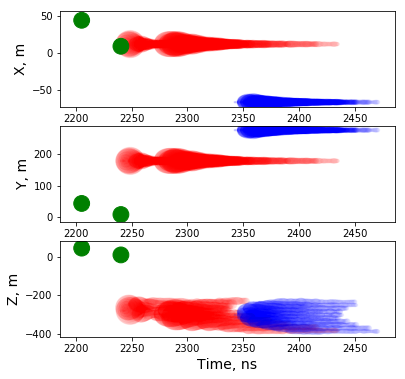

In [21]:
make_plots(labels_DBS,hq_data,true_bangs[57])

In [ ]:
make_waveforms(labels_DBS,hq_data,I)

(3840,) (3840, 10) 11


In [ ]:
GM_data = []
for sample in hq_data:
    if not sample[4]<0: 
        for j in range(0,int(sample[4])):
            GM_data.append(sample)
GM_data = np.vstack(GM_data)

In [271]:
GM = GaussianMixture(n_components=2).fit(hq_data[:,0:4])
labels_GM = GM.predict(hq_data[:,0:4])
unique, counts = np.unique(labels_GM, return_counts=True)
print dict(zip(unique, counts))

{0: 333, 1: 307}


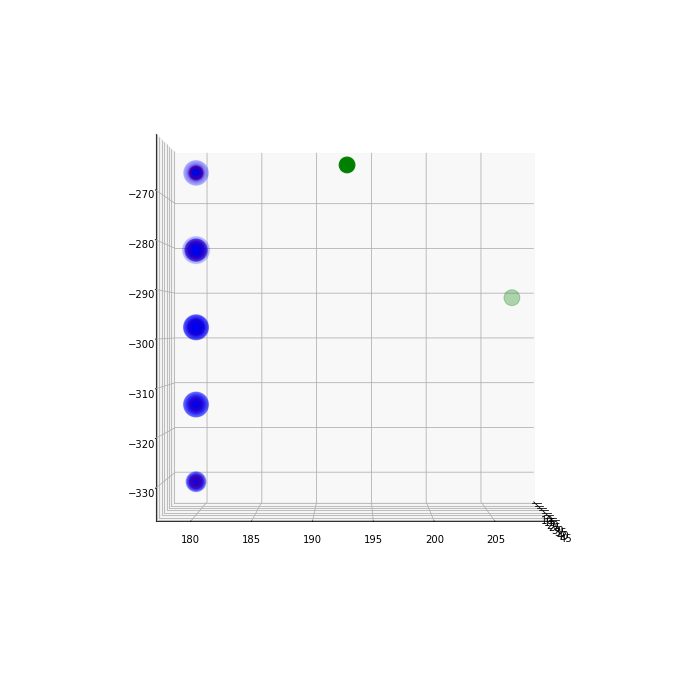

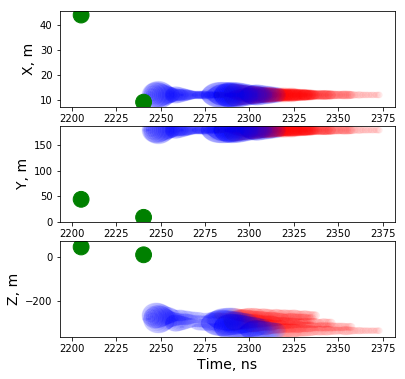

In [272]:
make_plots(labels_GM,hq_data,true_bangs[57])

(640,) (640, 10) 11


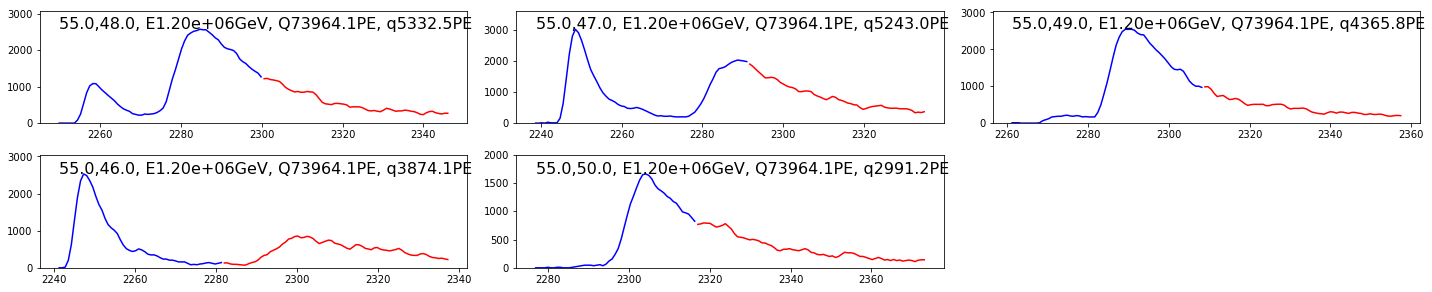

In [273]:
make_waveforms(labels_GM,hq_data,I)

In [290]:
GM2 = GaussianMixture(n_components=2).fit(GM_data[:,0:4])
labels_GM2 = GM.predict(hq_data[:,0:4])
unique, counts = np.unique(labels_GM2, return_counts=True)
print dict(zip(unique, counts))

{0: 278, 1: 362}


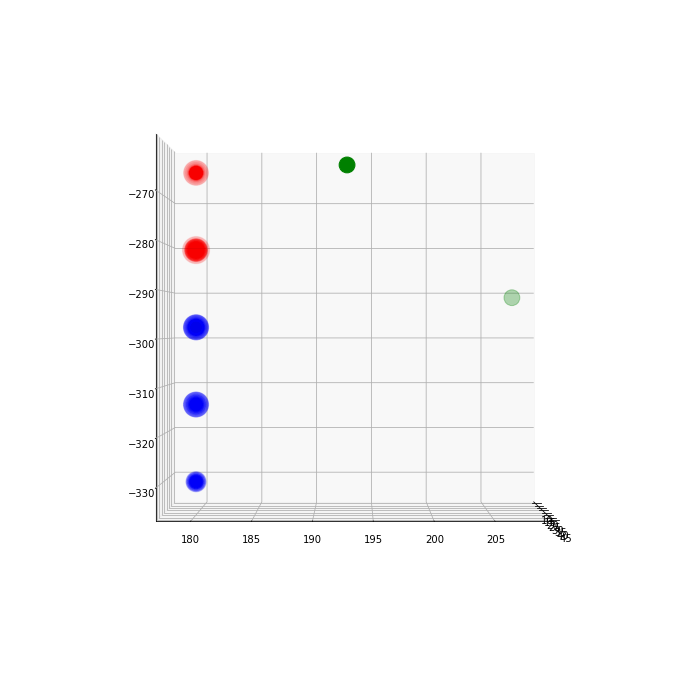

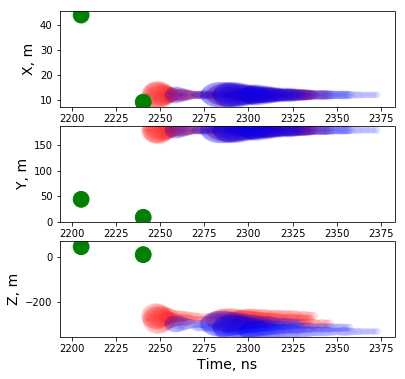

In [291]:
make_plots(labels_GM2,hq_data,true_bangs[57])

(640,) (640, 10) 11


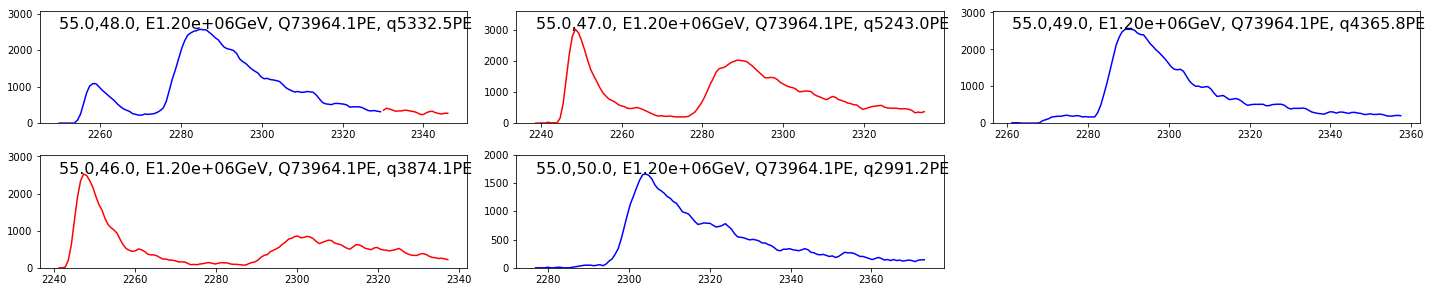

In [292]:
make_waveforms(labels_GM2,hq_data,I)

In [280]:
AG = AgglomerativeClustering(n_clusters=2, linkage = 'ward').fit(hq_data[:,0:4])
labels_AG = AG.labels_
unique, counts = np.unique(labels_AG, return_counts=True)
print dict(zip(unique, counts))

{0: 467, 1: 173}


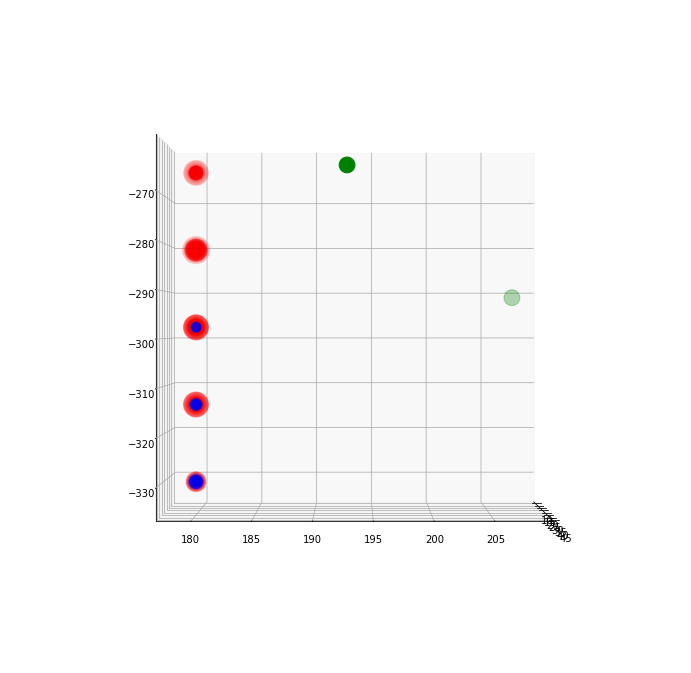

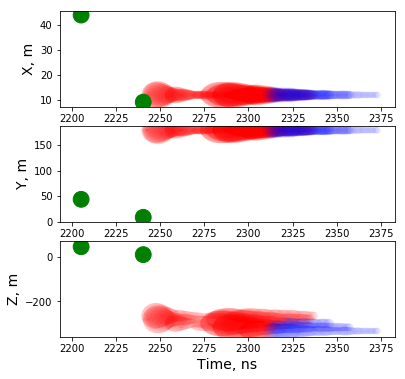

In [281]:
make_plots(labels_GM,hq_data,true_bangs[57])

(640,) (640, 10) 11


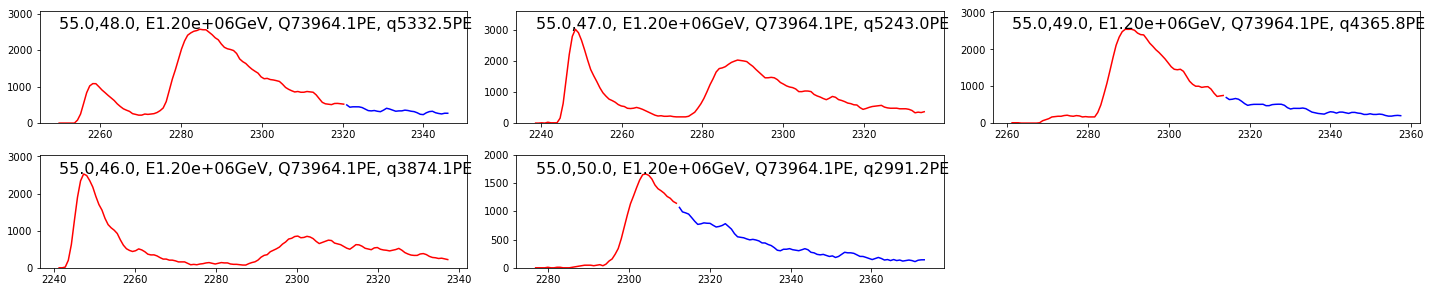

In [282]:
make_waveforms(labels_AG,hq_data,I)

In [293]:
KM = KMeans(n_clusters=2).fit(hq_data[:,0:4],hq_data[:,4])
labels_KM = KM.predict(hq_data[:,0:4])
unique, counts = np.unique(labels_KM, return_counts=True)
print dict(zip(unique, counts))

{0: 321, 1: 319}


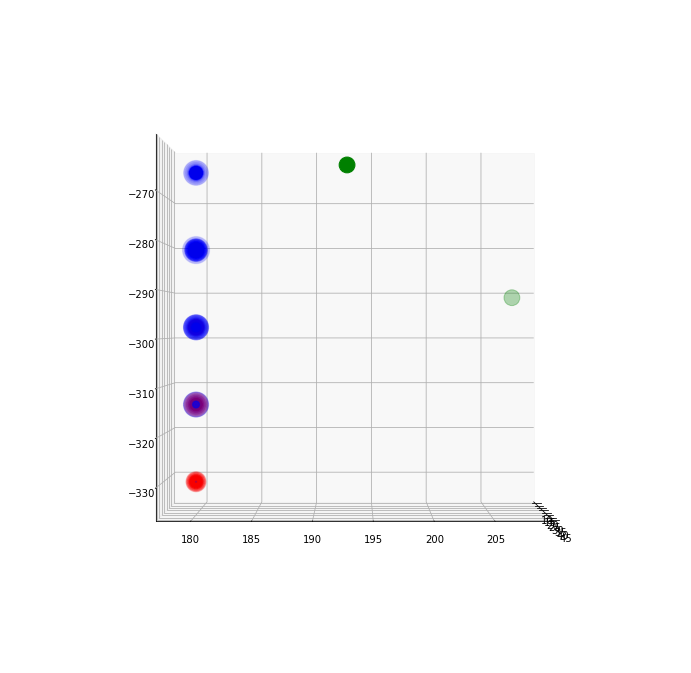

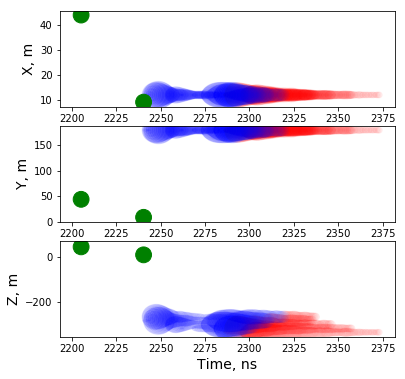

In [294]:
make_plots(labels_KM,hq_data,true_bangs[57])

(640,) (640, 10) 11


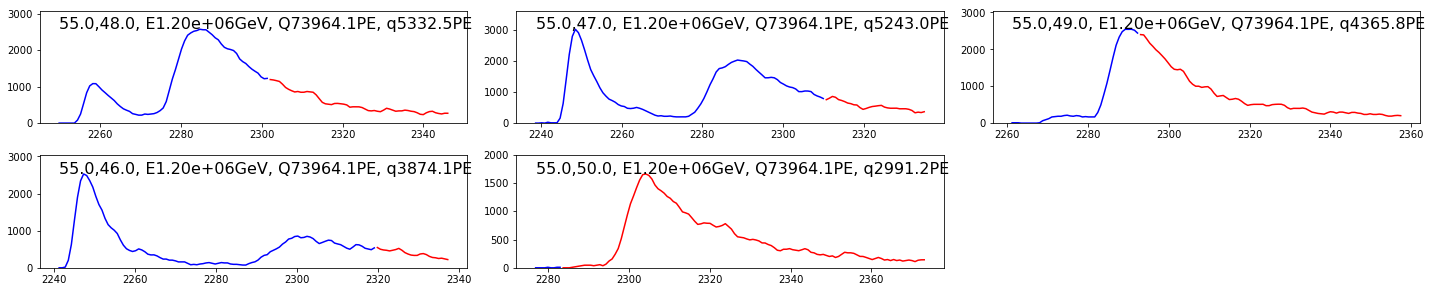

In [295]:
make_waveforms(labels_KM,hq_data,I)

In [296]:
import skfuzzy as fuzz

ImportError: No module named skfuzzy